# Proyecto 1: Analítica de textos

## Miembros
- Mariana Pineda Miranda - 202123330
- Isaac David Bermúdez- 202014146
- Joseph Linares Gutierrez - 202111887

In [124]:
import re

import pandas as pd
from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier



pd.set_option('display.max_columns', None)   # todas las columnas
pd.set_option('display.width', None) 

## Perfilamiento y análisis de datos

### Carga de datos

In [125]:
dataTrain = pd.read_csv("data/train.csv")
dataTest = pd.read_csv("data/test.csv")

In [126]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


### Conteo de elementos

In [127]:
dataTrain['textos'].value_counts()

textos
Aunque existen programas para convertirse específicamente en profesor de lengua materna, o en profesor de SAS (también solo a través del programa de profesor de asignaturas), no están integrados en otros programas de profesorado (Utbildningsdepartementet (Ministerio de Educación e Investigación), 2018,193]). En 2016, el Gobierno creó un comité especial para investigar este asunto. El informe del Comité incluía varias propuestas sobre la forma en que el SAS, la lengua materna y los conocimientos lingüísticos podrían tener una mayor presencia en los programas de formación del profesorado.                                                                                                                                                                                                                                                                                                                                                                                                                

In [128]:
conteoclases = dataTrain['labels'].value_counts()
conteoclases

labels
4    1025
3     894
1     505
Name: count, dtype: int64

#### Grafico de barras distribución de datos

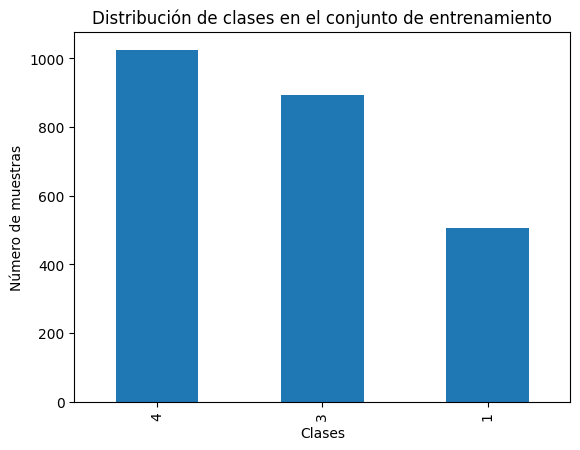

In [129]:
conteoclases.plot(kind='bar', title='Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Clases')
plt.ylabel('Número de muestras')
plt.show()

#### Pie chart distribución de datos

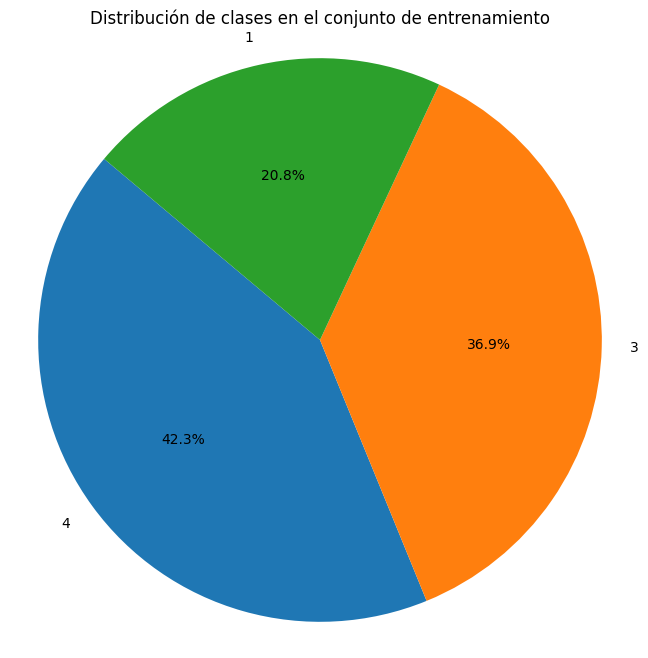

In [130]:
#Grafico de pastel distribución de datos
plt.figure(figsize=(8, 8))
plt.pie(conteoclases, labels=conteoclases.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.axis('equal')
plt.show()

In [131]:
dataTrain['textos'].str.len().describe()

count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: textos, dtype: float64

### Nulidad de elementos

In [132]:
dataTrain.isnull().sum()

textos    0
labels    0
dtype: int64

#### Ver si hay duplicados

In [133]:
dataTrain.duplicated().sum()

np.int64(0)

## Tratamiento de Datos

### Establecer StopWords (scapy)

In [134]:
from spacy.lang.es.stop_words import STOP_WORDS

# Listas de palabras a agregar (adicionar a stopwords)
palabras_conectoras = ['y', 'e', 'además', 'también', 'incluso', 'más', 'pero', 'aunque', 'sino']

# Listas de palabras a conservar (eliminar de stopwords)
palabras_de_Negacion = ['no', 'ni', 'nunca', 'jamás', 'tampoco',
                        'sin', 'ningún', 'ninguna', 'ninguno', 
                        'ningunos', 'ningunas', 'nada', 'nadie',
                        'haber', 'faltar', 'carecer','escasez', 
                        'ausencia', 'inaccesible', 'inaccesibilidad']

palabras_de_poder = ['puedo', 'puede', 'pueden', 'podemos', 'podría', 'podrían']


STOPWORDS = set(STOP_WORDS)
STOPWORDS = {w.lower() for w in STOPWORDS}

STOPWORDS.update(palabras_conectoras)
STOPWORDS.difference_update(palabras_de_Negacion)
STOPWORDS.difference_update(palabras_de_poder)

print(len(STOP_WORDS))
print(STOP_WORDS)

521
{'éstos', 'medio', 'aquéllos', 'tienen', 'estará', 'consiguen', 'debido', 'hubo', 'ese', 'nuevos', 'cuántos', 'cualquier', 'vosotros', 'quiénes', 'propia', 'porque', 'realizar', 'seis', 'haya', 'cuánto', 'he', 'mis', 'ambos', 'sido', 'unas', 'aunque', 'lo', 'podria', 'pasada', 'ningún', 'qué', 'dijo', 'hasta', 'todavía', 'total', 'era', 'no', 'en', 'muchas', 'quedó', 'cual', 'diferentes', 'final', 'me', 'muy', 'al', 'la', 'soy', 'aqui', 'sabemos', 'decir', 'eras', 'suyos', 'dia', 'mejor', 'pueda', 'aun', 'toda', 'habían', 'solamente', 'encuentra', 'pocas', 'ultimo', 'mas', 'ya', 'aquello', 'tuvo', 'ver', 'quiere', 'verdad', 'tus', 'nuevas', 'que', 'otros', 'usan', 'demás', 'podrian', 'tu', 'bastante', 'cuál', 'sólo', 'asi', 'cada', 'propio', 'nada', 'tenía', 'quizás', 'anterior', 'bajo', 'te', 'uso', 'por', 'consigo', 'según', 'ellos', 'ser', 'tres', 'veces', 'les', 'fueron', 'fin', 'serán', 'parece', 'unos', 'contra', 'tanto', 'aquel', 'así', 'podemos', 'donde', 'buen', 'tampoco',

### Cargar el modelo NLP (scapy)

In [135]:
import spacy

nlp = spacy.load('es_core_news_sm', disable=['ner','textcat']) # no se utiliza NER ni textcat


### Lematización + Normalización de palabras - Minusculas y acentos 

In [136]:
def lematizarTexto(textos):
    return [" ".join(t.lemma_.lower() for t in doc if t.is_alpha)
            for doc in nlp.pipe(textos, batch_size=128)]

dataTrain['lemas'] = lematizarTexto(dataTrain['textos'].astype(str).tolist())

In [137]:
dataTrain['lemas']

0       aprendizaje y educación él considerar sinónir ...
1       para el niño más pequeño bebé y niño pequeño e...
2       además el formación de especialista en medicin...
3       en el país de el ocde él tender a pasar de el ...
4       este grupo él centrar en el persona que padece...
                              ...                        
2419    el tutoer de carrera estar diseñar para apoyar...
2420    fuente ministerio de educación el tasas intern...
2421    y desde el pnud haber ser pionero en el puesta...
2422    sin embargo este falla del mercado implicar qu...
2423    aunque existir programa para convertir él espe...
Name: lemas, Length: 2424, dtype: object

### Vectorización con TF-IDF

In [138]:
textoVectorizado = TfidfVectorizer(
    stop_words=sorted(STOPWORDS),
    ngram_range=(1,2),
    min_df=2, 
    max_df=0.9,
    lowercase=True,
    strip_accents=None 
)

X = textoVectorizado.fit_transform(dataTrain["lemas"].fillna("").astype(str))
y = dataTrain["labels"].to_numpy()

## Algoritmos

### Logistic Regression - Joseph Linares

F1-score promedio: 0.9542597353431148
              precision    recall  f1-score   support

           1       0.97      0.88      0.92       101
           3       0.94      0.96      0.95       179
           4       0.96      0.99      0.97       205

    accuracy                           0.95       485
   macro avg       0.96      0.94      0.95       485
weighted avg       0.95      0.95      0.95       485



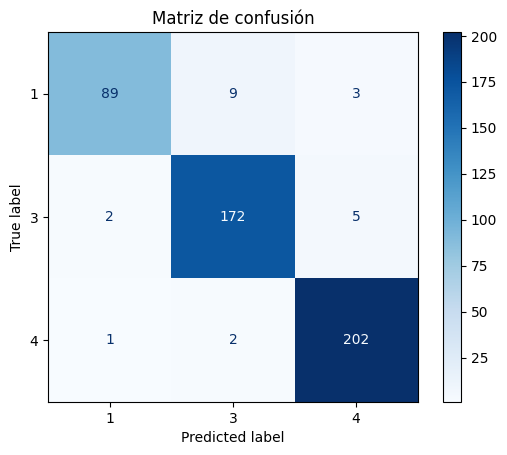

In [139]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print("F1-score promedio:", f1_score(y_val, y_pred, average='weighted'))
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()

### Naive Bayes - Mariana Pineda Miranda


TEST DATA
Accuracy: 0.9402061855670103

Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.78      0.87       112
           3       0.93      0.98      0.95       168
           4       0.93      1.00      0.96       205

    accuracy                           0.94       485
   macro avg       0.95      0.92      0.93       485
weighted avg       0.94      0.94      0.94       485



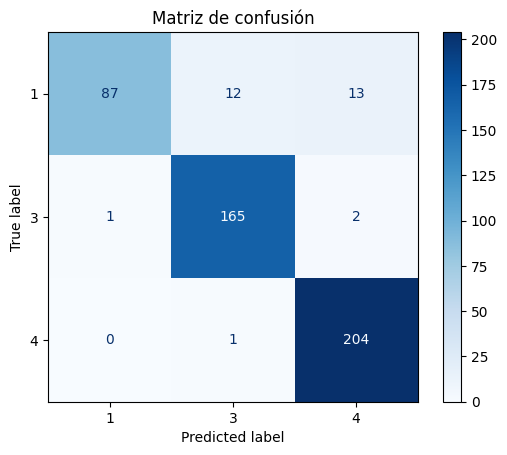



TRAIN DATA
Accuracy: 0.9783393501805054

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.91      0.95       393
           3       0.98      0.99      0.99       726
           4       0.97      1.00      0.98       820

    accuracy                           0.98      1939
   macro avg       0.98      0.97      0.97      1939
weighted avg       0.98      0.98      0.98      1939



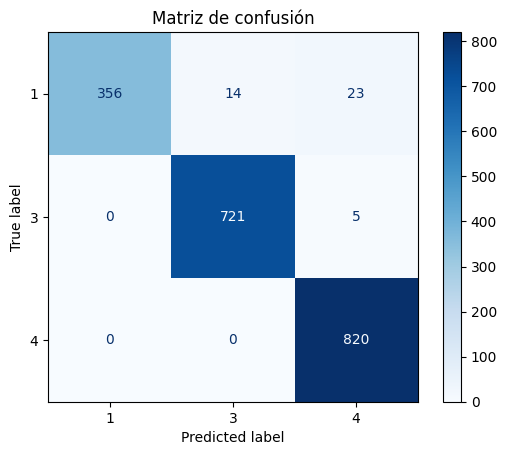

In [140]:
#Divido mis datos entre test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Algoritmo de Naive Bayes
naive_b = MultinomialNB()
naive_b.fit(X_train, y_train)

y_pred = naive_b.predict(X_test)
y_pred_train = naive_b.predict(X_train)

print("TEST DATA")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()
print("\n")

print("TRAIN DATA")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()



### Linear SVM - Mariana Pineda

TEST DATA
Accuracy: 0.9732
F1-macro: 0.9711

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.96      0.96       112
           3       0.97      0.98      0.97       168
           4       0.98      0.98      0.98       205

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



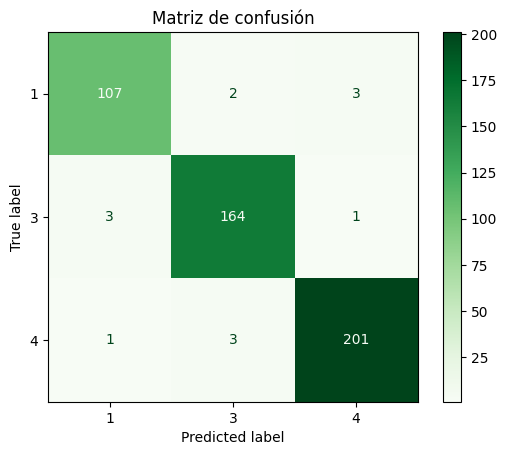



TRAIN DATA
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       393
           3       1.00      1.00      1.00       726
           4       1.00      1.00      1.00       820

    accuracy                           1.00      1939
   macro avg       1.00      1.00      1.00      1939
weighted avg       1.00      1.00      1.00      1939



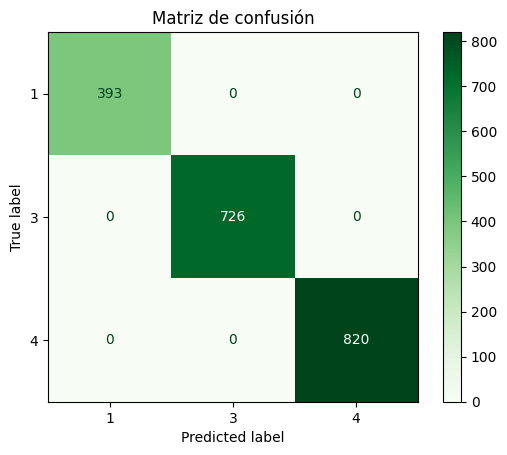

In [141]:
base = LinearSVC()
calibrador = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=5)

calibrador.fit(X_train, y_train)

y_pred = calibrador.predict(X_test)
y_pred_train = calibrador.predict(X_train)
y_proba = calibrador.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

print("TEST DATA")
print(f"Accuracy: {acc:.4f}")
print(f"F1-macro: {f1m:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Greens')
plt.title("Matriz de confusión")
plt.show()
print("\n")

print("TRAIN DATA")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Greens')
plt.title("Matriz de confusión")
plt.show()

### Random Forest - Isaac Bermudez

TEST DATA
Accuracy: 0.9402061855670103

Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.78      0.87       112
           3       0.93      0.98      0.95       168
           4       0.93      1.00      0.96       205

    accuracy                           0.94       485
   macro avg       0.95      0.92      0.93       485
weighted avg       0.94      0.94      0.94       485



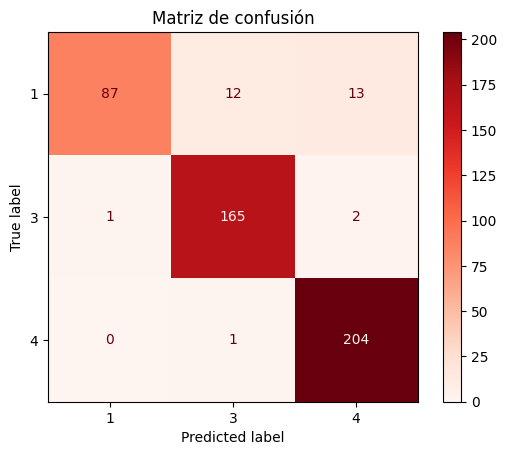



TRAIN DATA
Accuracy: 0.9783393501805054

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.91      0.95       393
           3       0.98      0.99      0.99       726
           4       0.97      1.00      0.98       820

    accuracy                           0.98      1939
   macro avg       0.98      0.97      0.97      1939
weighted avg       0.98      0.98      0.98      1939



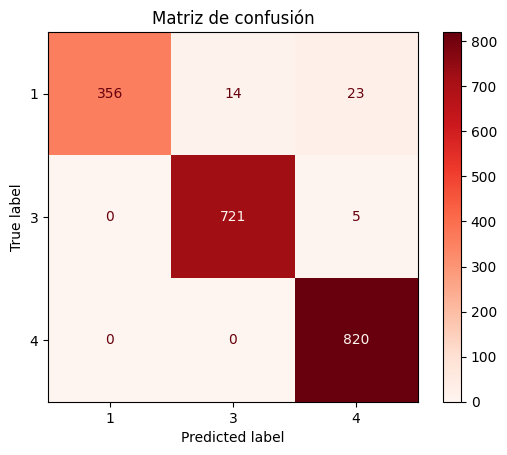

In [147]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)

y_pred = naive_b.predict(X_test)
y_pred_train = naive_b.predict(X_train)

print("TEST DATA")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Reds')
plt.title("Matriz de confusión")
plt.show()
print("\n")


print("TRAIN DATA")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Reds')
plt.title("Matriz de confusión")
plt.show()



## Prueba con datos del test


### Transformación de los datos de test

In [148]:
dataTest['lemas'] = lematizarTexto(dataTest['Textos_espanol'].astype(str).tolist())
X_datos_test = textoVectorizado.transform(dataTest["lemas"].fillna("").astype(str))


### Aplicación SVM a datos test

In [144]:
resultado = calibrador.predict(X_datos_test)
dataTest['predicciones'] = resultado
dataTest[['Textos_espanol', 'predicciones']].to_excel('resultados_svm.xlsx', index=False)
